In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import Rbf, interp1d, griddata
from scipy.signal import find_peaks
#plt.rcParams['figure.figsize'] = 5, 4

First define the update function for the ODEs

In [17]:
def step(p1, p2, p3, r, mu0, k, gamma, d, e, n, Dt):
  # Compute growth rates on mesh
  mu = mu0 * np.exp(-k*r) # K = 1/k = length scale of decay in growth rate
  # Update protein concs
  nextp1 = p1 + ((d + e*(p3**n))/(1 + p3**n) - gamma*p1 - mu*p1) * Dt
  nextp2 = p2 + ((d + e*(p1**n))/(1 + p1**n) - gamma*p2 - mu*p2) * Dt
  nextp3 = p3 + ((d + e*(p2**n))/(1 + p2**n) - gamma*p3 - mu*p3) * Dt
  # Update radial position relative to colony edge
  nextr = r + ( mu0/k * (1 - np.exp(-k*r)) ) * Dt
  return nextp1, nextp2, nextp3, nextr

Next define a function to compute the kymograph by running simulations.

In [18]:
def compute_kymo(
    Dt = 0.025,
    gamma = 0.3,
    mu0 = 0.5,
    R0 = 1,
    k = .1,
    d = 198.,
    e = 0,
    n = 2,
    nx = 100,
    nt = 2000
):
  # Initial conditions on 1d mesh
  r = np.linspace(0,R0,nx, endpoint=True)
  t = 0
  p1 = np.zeros((nx,))
  p2  = np.zeros((nx,))
  p3 = np.ones((nx,)) * 5.
  p1_list = [p1] 
  p2_list = [p2]
  p3_list = [p3]
  r_list = [r]
  t_list = [[t]*nx]
  # Integrate equations forward
  for i in range(nt-1):
    ## Colony radius
    R = R0 + mu0/k * i * Dt

    # Integrate the ODEs
    p1,p2,p3,rnew = step(p1, p2, p3, r, mu0, k, gamma, d, e, n, Dt)

    #print(rnew.max())
    
    # New regular mesh in r axis
    new_mesh = np.linspace(0,R,nx, endpoint=True)

    # Interpolate result to regular mesh
    p1 = interp1d(rnew, p1, fill_value='extrapolate')(new_mesh)  
    p2 = interp1d(rnew, p2, fill_value='extrapolate')(new_mesh)  
    p3 = interp1d(rnew, p3, fill_value='extrapolate')(new_mesh)  

    p1_list.append(p1) 
    p2_list.append(p2) 
    p3_list.append(p3) 

    # Replace mesh for next iteration
    r = new_mesh
    r_list.append(r)  
    # Update time
    t = t + Dt
    t_list.append([t]*nx)

  # Make numpy arrays for convenience
  ap1 = np.array(p1_list).transpose()
  ap2 = np.array(p2_list).transpose()
  ap3 = np.array(p3_list).transpose()
  ar = np.array(r_list).transpose()
  at = np.array(t_list).transpose()

  # Remap kymograph to R coords = distance from center of colony
  R = R0 + at*mu0/k
  aR = R - ar
  points = np.stack((at[:,::10].ravel(), aR[:,::10].ravel())).transpose()

  ti = np.linspace(0, at.max(), int(nt//10), endpoint=True)
  ri =  np.linspace(0, aR.max(), nx, endpoint=True)
  mti,mri = np.meshgrid(ti, ri)
  xi = np.stack((mti.ravel(),mri.ravel())).transpose()

  grid1 = griddata(points, ap1[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid2 = griddata(points, ap2[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid3 = griddata(points, ap3[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid1 = grid1.reshape((nx,int(nt//10)))
  grid2 = grid2.reshape((nx,int(nt//10)))
  grid3 = grid3.reshape((nx,int(nt//10)))

  # Stack to get 3 channel normalized image
  kymo = np.stack((grid1/np.nanmax(grid1), grid2/np.nanmax(grid2), grid3/np.nanmax(grid3))).transpose()

  # Kymogroph in original relative coordinates, no remapped
  unmapped_kymo = np.stack((ap1[:,::10]/np.nanmax(ap1[:,::10]), 
                            ap2[:,::10]/np.nanmax(ap2[:,::10]), 
                            ap3[:,::10]/np.nanmax(ap3[:,::10]))).transpose()

  # Remove data from kymograph outside colony
  nkymo = np.zeros_like(kymo)
  nkymo[:,:,:] = kymo
  for i in range(nkymo.shape[0]):
    # Colony radius
    R = R0 + mu0/k * i * Dt * 10
    # Index into grid
    Ridx = int(R * nx / (R0 + mu0/k * nt * Dt))
    nkymo[i,Ridx+1:] = np.nan
  
  tscale = at.max()/nt*10
  rscale = aR.max()/nx
  return nkymo, unmapped_kymo, tscale, rscale

Now we make functions to compute the wavelength and wave speed of the travelling wave.

In [19]:
def compute_wave_length(unmapped_kymo, speed, tscale=1, mu0=1, k=0.1, debug=False):
  if debug:
    plt.figure()
    plt.imshow(unmapped_kymo, aspect='auto')

  mean_wave_lengths = []
  for c in range(3):
    # Take the wave at R=0
    signal = unmapped_kymo[:,0,c]
    pks,props = find_peaks(signal, prominence=0.1)
    if debug:
      plt.figure()
      plt.plot(signal)
      plt.plot(pks, signal[pks], '+')
    # Compute the frequency
    if len(pks)>1:
      # Compute average period
      mean_period = np.mean(np.diff(pks)) * tscale
      mean_freq = 1 / mean_period
      mean_wave_length = (speed + mu0/k) / mean_freq
      mean_wave_lengths.append(mean_wave_length)
  return np.mean(mean_wave_lengths)

def compute_wave_speed(nkymo, dt=1, tscale=1, rscale=1, debug=False):
  if debug:
    plt.figure()
    plt.imshow(nkymo)

  # Find peaks in radial axis
  pks_list = []
  for channel in range(3):
    for i in range(1, nkymo.shape[0], 1):
      nk = nkymo[i,1:-1,channel]
      idx = ~np.isnan(nk) # times when both signals are within the colony
      nk = nk[idx]
      pks,props = find_peaks(nk, prominence=0.1)
      #print(props['peak_heights'])
      # Trim off end points
      tpks = []
      for p in pks:
        if p>1 and p<len(nk)-5:
          tpks.append(p)
          if debug:
            plt.plot(p, i, '.w')
      pks_list.append(tpks)

  # Track peaks from one timepoint to next +dt
  speeds = []
  for i in range(len(pks_list)-dt):
    pks = pks_list[i]
    # Peaks at next time point
    next_pks = pks_list[i+dt]
    for pk in pks:
      # Find closest peak at next time point
      min_dist = 10
      for next_pk in next_pks:
        if next_pk<=pk:
          dist = np.abs(next_pk-pk)
          if dist<min_dist:
            min_dist = dist
      # Make a threshold to avoid wrap around effects
      if min_dist<10:
        speed = min_dist*rscale / (dt*tscale)
      else:
        speed = np.nan
      speeds.append(speed)
      
  # Average of speeds of peaks, make sure we have enough data for estimate
  if len(speeds)>5:
    mean_speed = np.nanmean(speeds)
  else:
    mean_speed = np.nan

  nt,nx = kymo.shape[:2]
  x1 = nt*mean_speed/rscale*tscale
  y1 = nx/mean_speed*rscale/tscale
  if x1<nx:
    plt.plot([0,x1], [nt,0], 'w')
  elif y1<nt:
    plt.plot([0,nx], [y1,0], 'w')

  #print('Mean wave speed = ', mean_speed)
  return mean_speed

We need to define a new function to compute the wavelength for CM simulations because we have no unmapped kymograph. Here we find the leading edge of the colony directly from the kymograph, with NaN outside the colonny.

In [20]:
def signal_at_edge(nkymo, channel, tscale=1, rscale=1, debug=False):
    if debug:
        plt.figure()
        plt.imshow(nkymo, aspect='auto')

    nt,nx = nkymo.shape[:2]
    signal = []
    start_time = 0
    for t in range(nt):
        idx = np.where(~np.isnan(nkymo[t,:,channel]))[0]
        if len(idx)>0:
            last_idx = idx[-1] # position of edge of colony at time t
            signal.append(nkymo[t,last_idx,channel])
            if debug:
                plt.plot(last_idx, t, 'w.')
        else:
            # This will find the first time at which the colony has non-zero radius
            start_time = t
    # Compute mean speed of front, this will give inaccurate wavelength 
    # estimates if the colony is not growing linearly
    avg_front_speed = last_idx * rscale / (nt-start_time) / tscale
    return np.array(signal), avg_front_speed

def compute_wave_length_CM(nkymo, speed, tscale=1, rscale=1, mu0=1, k=0.1, debug=False):
  mean_wave_lengths = []
  for c in range(3):
    # Take the wave at R=0
    signal, front_speed = signal_at_edge(nkymo, c, tscale=tscale, rscale=rscale, debug=debug)
    if len(signal)>2:
        pks,props = find_peaks(signal, prominence=0.1)
        if debug:
          plt.figure()
          plt.plot(signal)
          plt.plot(pks, signal[pks], '+')
        # Compute the frequency
        if len(pks)>1:
          # Compute average period
          mean_period = np.mean(np.diff(pks)) * tscale
          mean_freq = 1 / mean_period
          mean_wave_length = (speed + front_speed) / mean_freq
          mean_wave_lengths.append(mean_wave_length)
  return np.mean(mean_wave_lengths)

Here we construct phase space plots for wave speed and wavelength depending on the parameters gamma, mu0, d, and k.

First consider gamma and d, with mu0=1 and k=0.1

In [ ]:
speeds = []
wavelengths = []
mu0 = 1
k = 0.1
ngammas = 10
nds = 10
gammas = np.logspace(-2, 0, ngammas, endpoint=True)
ds = np.logspace(2, 6, nds, endpoint=True)
for gammai in gammas:
  for di in ds:
    nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gammai, mu0=mu0, d=di, k=k)
    speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale)
    wavelength = compute_wave_length(unmapped_kymo, speed, tscale=tscale, mu0=mu0, k=k)
    speeds.append(speed)
    wavelengths.append(wavelength)
    #print('speed=%02f, wavelength=%02f, gamma=%02f, mu0=%02f'%(speed, wavelength/rscale, gammai, 1))

# Convert the results to arrays and reshape to the grid
aspeeds = np.array(speeds)
aspeeds = aspeeds.reshape((ngammas,nmus))
awavelengths = np.array(wavelengths)
awavelengths = awavelengths.reshape((ngammas,nmus))

Plot the resulting phase space.

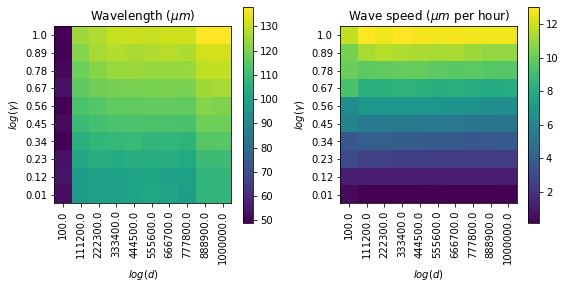

In [14]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(awavelengths, origin='lower')
plt.xlabel('$log(d)$')
plt.xticks(np.arange(nds)[::1], np.round(ds[::1],2), rotation=90)
plt.ylabel('$log(\gamma)$')
plt.yticks(np.arange(ngammas)[::1], np.round(gammas[::1],2))
plt.colorbar()
plt.title('Wavelength ($\mu m$)')

plt.subplot(1,2,2)
plt.imshow(aspeeds, origin='lower')
plt.xlabel('$log(d)$')
plt.xticks(np.arange(nds)[::1], np.round(ds[::1],2), rotation=90)
plt.ylabel('$log(\gamma)$')
plt.yticks(np.arange(ngammas)[::1], np.round(gammas[::1],2))
plt.colorbar()
plt.title('Wave speed ($\mu m$ per hour)')

plt.tight_layout()

Now consider mu0 and k, the physical/environmental parameters, with d=1e4 and gamma=0.3.

In [0]:
speeds = []
wavelengths = []
gamma = 0.3
d = 1e2
nmus = 10
nks = 10
mus = np.logspace(-1, 0, nmus, endpoint=True)
ks = np.logspace(-2, 0, nks, endpoint=True)
for mui in mus:
  for ki in ks:
    nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, mu0=mui, d=d, k=ki)
    speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale)
    wavelength = compute_wave_length(unmapped_kymo, speed, tscale=tscale, mu0=mui, k=ki)
    speeds.append(speed)
    wavelengths.append(wavelength)
    #print('speed=%02f, wavelength=%02f, gamma=%02f, mu0=%02f'%(speed, wavelength/rscale, gammai, 1))

# Convert the results to arrays and reshape to the grid
aspeeds = np.array(speeds)
aspeeds = aspeeds.reshape((ngammas,nmus))
awavelengths = np.array(wavelengths)
awavelengths = awavelengths.reshape((ngammas,nmus))

Again plot the resulting phase space.

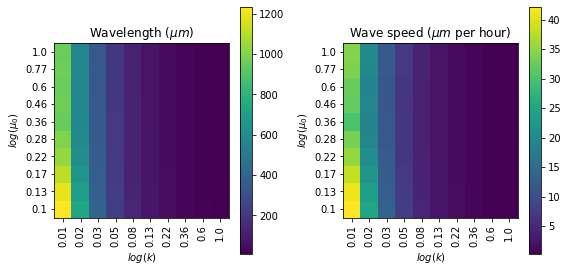

In [62]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(awavelengths, origin='lower')
plt.xlabel('$log(k)$')
plt.xticks(np.arange(nks)[::1], np.round(ks[::1],2), rotation=90)
plt.ylabel('$log(\mu_0)$')
plt.yticks(np.arange(nmus)[::1], np.round(mus[::1],2))
plt.colorbar()
plt.title('Wavelength ($\mu m$)')

plt.subplot(1,2,2)
plt.imshow(aspeeds, origin='lower')
plt.xlabel('$log(k)$')
plt.xticks(np.arange(nks)[::1], np.round(ks[::1],2), rotation=90)
plt.ylabel('$log(\mu_0)$')
plt.yticks(np.arange(nmus)[::1], np.round(mus[::1],2))
plt.colorbar()
plt.title('Wave speed ($\mu m$ per hour)')

plt.tight_layout()

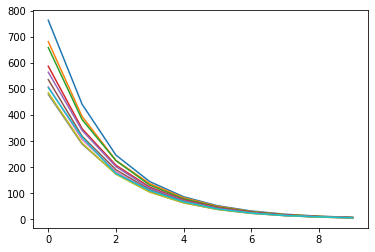

In [12]:
plt.plot(awavelengths.transpose());

Let look at some kymographs for limiting cases of the parameters mu0 and gamma.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '$\\gamma = 1$, $\\mu = 1$')

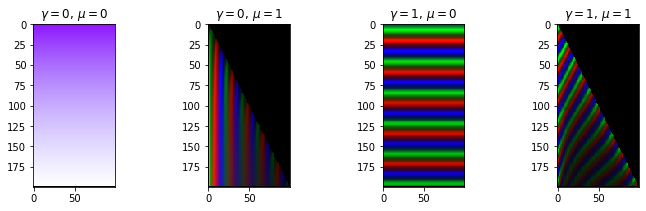

In [5]:
plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=0, mu0=0, d=1e4)
plt.imshow(nkymo)
plt.title('$\gamma = 0$, $\mu = 0$')
plt.subplot(1,4,2)
nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=0, mu0=1, d=1e4)
plt.imshow(nkymo)
plt.title('$\gamma = 0$, $\mu = 1$')
plt.subplot(1,4,3)
nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=1, mu0=0, d=1e4)
plt.imshow(nkymo)
plt.title('$\gamma = 1$, $\mu = 0$')
plt.subplot(1,4,4)
nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=1, mu0=1, d=1e4)
plt.imshow(nkymo)
plt.title('$\gamma = 1$, $\mu = 1$')

Using the debug flag we can check the intermediate computations to make sure our analysis is correct.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.813480146813481 93.36527777777648
0.499499999999993 0.2597499999999965


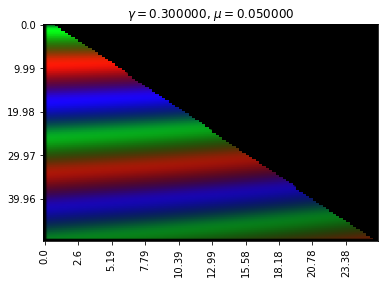

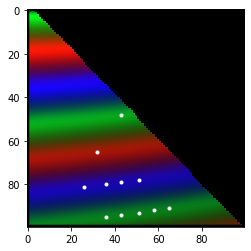

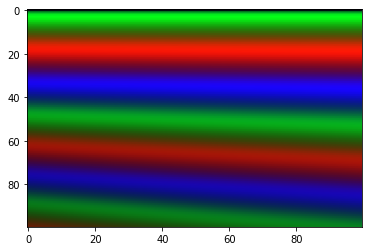

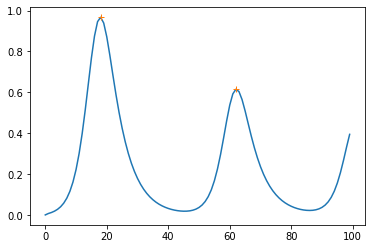

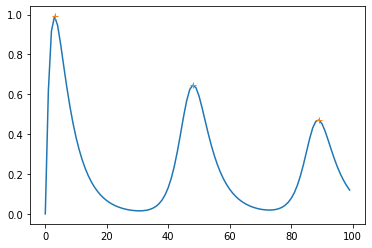

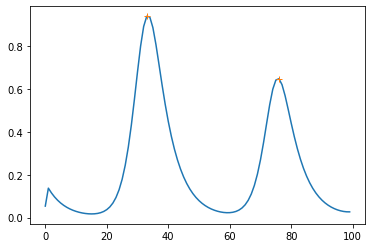

In [66]:
gamma = 0.3
mu0 = 0.05
k = 0.1
d = 198

nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, mu0=mu0, k=k, d=d, Dt=0.05, nt=1000)
plt.imshow(nkymo, aspect='auto')
plt.xticks(np.arange(0,100,10), np.round(np.arange(0,100,10)*rscale, 2), rotation=90)
plt.yticks(np.arange(0,100,20), np.round(np.arange(0,100,20)*tscale, 2))
plt.title('$\gamma = %02f$, $\mu = %02f$'%(gamma, mu0))

speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale, debug=True)
wavelength = compute_wave_length(unmapped_kymo, speed, tscale=tscale, mu0=mu0, k=k, debug=True)
print(speed, wavelength)
print(tscale, rscale)

Try the methods on a kymograph from a CellModeller simulation.

In [11]:
kymo = np.load('kymos/kymo_0.31622776601683794_10000.0.npy')
nkymo = kymo
nkymo[nkymo==0] = np.nan

1.7538461538461538 54.0165034965035


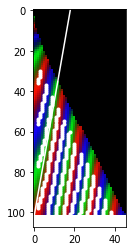

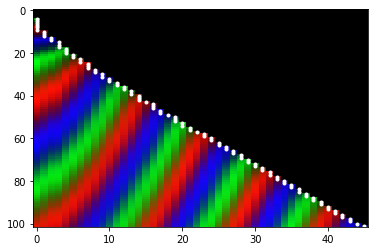

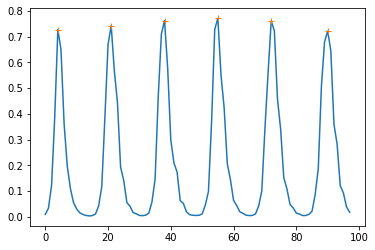

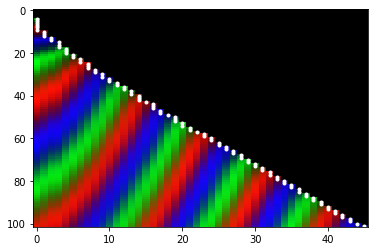

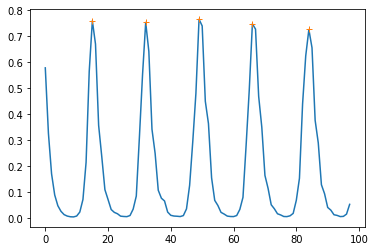

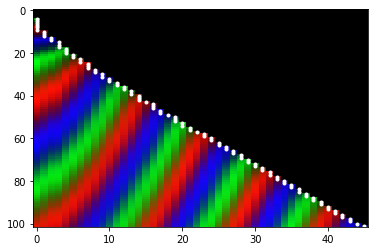

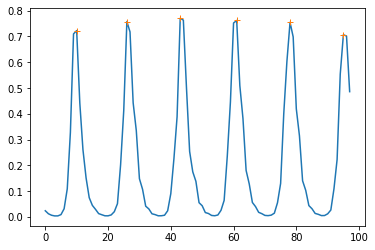

In [15]:
speed = compute_wave_speed(kymo, tscale=10*0.05, rscale=5, debug=True)
wavelength = compute_wave_length_CM(kymo, speed, tscale=10*0.05, rscale=5, debug=True)
print(speed, wavelength)

In [ ]:
## Pendings

In [ ]:
# OK Drive: upload 3 CM Sims, gamma=10

# GY:SIMS

#OK gamma = 0, d=10000
#OK new kymos
#OK upload new kymos
# analysis kymos: store figures in folders
#OK store (gamma, d, speed, wavelength)

# GY: draft

# OK FOR FIGURE 1: colony radius as function of time: simple growth gamma=10
# Figure 2: 1D model
# GY Figure 3: CM stuff (report)
# Figure 4: Comparing 1D with CM